In [543]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pylab
from random import randint

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [394]:
#https://github.com/smajida/mnist-fun/blob/master/keras_model.py
def add_gaussian_noise(digit, mean, stddev):
    ''' 
    This function adds gaussian noise to the matrix representations
    of the mnist digit
    IN:   
        (1) np array: the MNIST digit representations (n, 784)
        (2) float: the mean of the Gaussian to sample noise from
        (3) float: the standard deviation of the Gaussian to sample
            noise from. Note that the range of pixel values is
            0-255; 
    OUT: 
        (1) np array: noisy training data (n, 784)
    '''
    # #of images (10000 for mnist)
    n_imgs = digit.shape[0]
    # matrix size (784 for mnist)
    n_size = digit.shape[1]
    if stddev == 0:
        noise = np.zeros((n_imgs, n_size))
    else:
        # sample from normal dist
        noise = np.random.normal(mean, stddev/255.,(n_imgs, n_size))
    # add the noise to the data
    x_noisy = digit + noise
    # make sure all data points are in interval [0, 1]
    x_noisy = np.clip(x_noisy, 0., 1.)
    return x_noisy

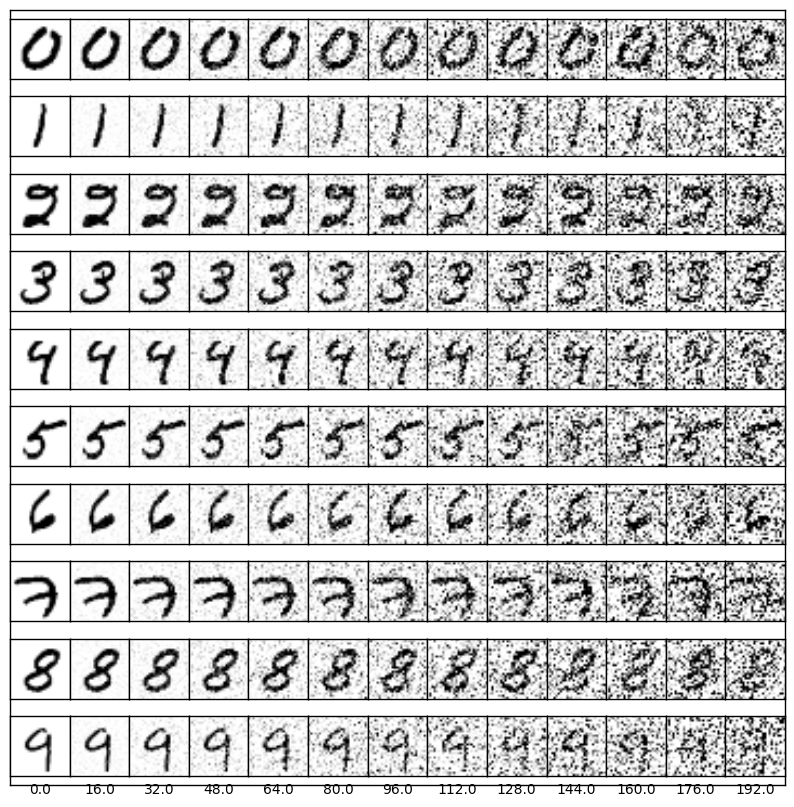

In [579]:
def show_all_noisy_digits(noise_stddevs, x_digit, y_label):
    ''' 
    IN:  
        (1) 1D numpy array: standard deviations of the Gaussian noise to add
            to example images from the X training data. Note that the image
            data has not yet been scaled from 0 to 1, but still has values
            between 0 and 255. Hardcoded to work with the len of this array
            at 97 (the total number of models trained) such that taking 
            every 8th element results in 13 examples (which is the hardcoded
            number of columns for this function)
        (2) (784, ) np array: the MNIST digit representation
        (3) 1D numpy array: y training data: the first instance of each digit
            will be taken from these labels so that an example of each
            digit can be shown
            EXAMPLE: [0,0,1,0,0,0,0,0,0,0] = the digit 2
    OUT: Plots
    
    This function displays an example of each digit from the X training data
    with increasing levels of Gaussian noise on top of it. The function is 
    hardcoded such that 13 examples of increasing noise will be shown. 
    '''
    fig = plt.figure(figsize=(10,10))
    outer_grid = gridspec.GridSpec(10, 13, wspace=0.0, hspace=0.0)
    pylab.xticks([])
    pylab.yticks([])
    
    # more efficient
    first_ind_of_each_num = {}
    for i in range(10):
        counter = 0
        # by inspection: this is enough
        while counter < 100: #len(mnist.test.labels):
            position = np.where(y_label[counter] == 1)[0][0]
            if position not in first_ind_of_each_num:
                first_ind_of_each_num[position] = counter
            counter +=1
    
    for col_ind, noise_stddev in zip(range(13), noise_stddevs[::8]):  
        x_digit_noisy = add_gaussian_noise(x_digit, 0, noise_stddev)
        
        for row_ind in range(10):
            ind_to_plot = col_ind + row_ind * 13
            ax = plt.Subplot(fig, outer_grid[ind_to_plot])
            first_ind_of_this_num = first_ind_of_each_num[row_ind]
            ax.imshow(x_digit_noisy[first_ind_of_this_num].reshape((28,28)), 
                      cmap=plt.cm.Greys)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
            if ax.is_last_row():
                ax.set_xlabel('{}'.format(noise_stddev))
            plt.subplots_adjust(wspace=0.0,hspace=0.0)
            
    # plt customization here.
    plt.show()
    
show_all_noisy_digits(noise_stddevs, digits, labels)

In [549]:
# create the stddeviations also used for the function above
# I just don't want to run the show_all_noisy_x_example function 
# every time. If you want to reuse it, put it after the stdevs= line
noise_stddevs = np.linspace(0, 192, 97)
digits, labels = mnist.train.images[:], mnist.train.labels[:]
# pick the 16, 32 ....
stddevs = noise_stddevs[::8]

In [306]:
# visualization 
# http://tneal.org/post/tensorflow-ipython/TensorFlowMNIST/
# A red/black/blue colormap
# Activation of weights
cdict = {'red':   [(0.0,  1.0, 1.0),
                    (0.25,  1.0, 1.0),
                    (0.5,  0.0, 0.0),
                    (1.0,  0.0, 0.0)],
        'green': [(0.0,  0.0, 0.0),
                    (1.0,  0.0, 0.0)],
        'blue':  [(0.0,  0.0, 0.0),
                       (0.5,  0.0, 0.0),
                       (0.75, 1.0, 1.0),
                       (1.0,  1.0, 1.0)]}
redblue = matplotlib.colors.LinearSegmentedColormap('red_black_blue',cdict,256)

In [586]:
def data_iterator(x, y):
    """ 
    A helper function to create batches for the training data 
    IN: 
        (1) np array: the training images
        (2) np array: the labels [0000010000]
    OUT:
        Batches to train on using iter_.next()
    """
    batch_idx = 0
    while True:
        # shuffle labels and features
        idxs = np.arange(0, len(x))
        np.random.shuffle(idxs)
        shuf_features = x[idxs]
        shuf_labels = y[idxs]
        batch_size = 100
        for batch_idx in range(0, len(x), batch_size):
            images_batch = shuf_features[batch_idx:batch_idx+batch_size]
            images_batch = images_batch.astype("float32")
            labels_batch = shuf_labels[batch_idx:batch_idx+batch_size]
            yield images_batch, labels_batch

def eval_noisy_data(noise_vals, digits, labels):
    ''' 
    This function trains the model on the respective noises
    IN:  
        (1) List: list of std deviations (stddevs)
    OUT: 
        (1) List: list of tuples (Noise, accuracy)
    '''
    accuracies = []
    for noise_val in noise_vals:
        # create the noisy data with the noise_vals
        # use training images 555000
        x_noisy = add_gaussian_noise(digits[:], 0, noise_val)
        # create the iterator
        iter_ = data_iterator(x_noisy, labels)
        
        # MODEL HERE 
        ##
        x = tf.placeholder(tf.float32, [None, 784])
        # 10 weights to learn
        w1 = tf.Variable(tf.zeros([784, 10]))
        # 10 biases to learn
        b1 = tf.Variable(tf.zeros([10]))

        #layer 2
        w2 = tf.Variable(tf.zeros([10, 10]))
        b2 = tf.Variable(tf.zeros([10]))

        # use softmax as activation
        # other options: sigmoid, softplus
        # SINGLE LAYER
        y = tf.nn.softmax(tf.matmul(x, w1) + b1)
        # 2 LAYER
        # y1 = tf.matmul(y1, w1) + b1
        # y = tf.nn.softmax(tf.matmul(y1, w2) + b2)

        y_ = tf.placeholder(tf.float32, [None, 10])

        cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
        
        # use gradient descent just because.
        train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

        init = tf.initialize_all_variables()
        sess = tf.Session()
        sess.run(init)

        # train 1000 batches of size 100 (defined in iterator function)
        for _ in range(1000):
            batch_xs, batch_ys = iter_.next()  #mnist.train.next_batch(100)
            sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

        correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        final = sess.run(accuracy, feed_dict={x: x_noisy, y_: labels})
        
        # append to the list
        accuracies.append((noise_val, final))
        
        
        # weight activations
        wts = w1.eval(sess)
        # digit 0 activation
        im = wts.flatten()[0::10].reshape((28,-1))
        plt.imshow(im, cmap = redblue, clim=(-1.0, 1.0))
        plt.colorbar()
        plt.show()
        
    return accuracies

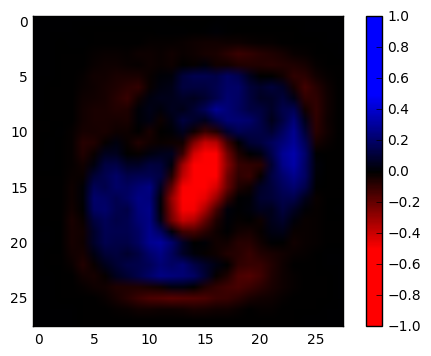

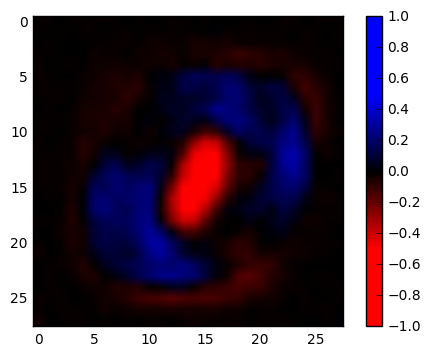

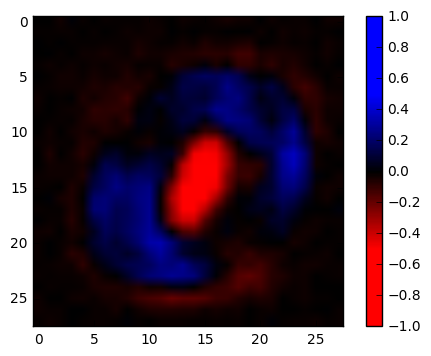

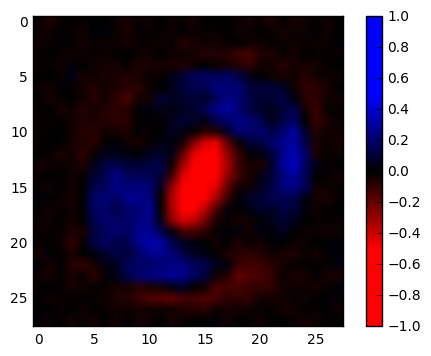

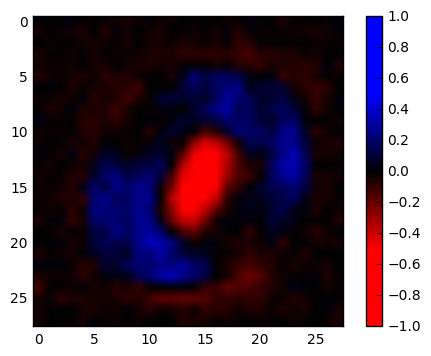

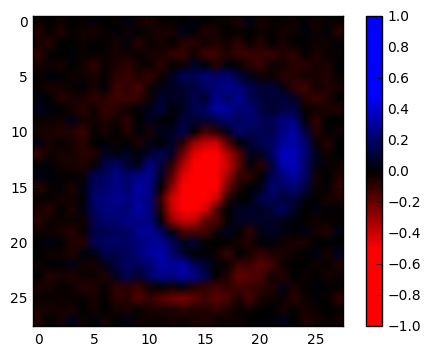

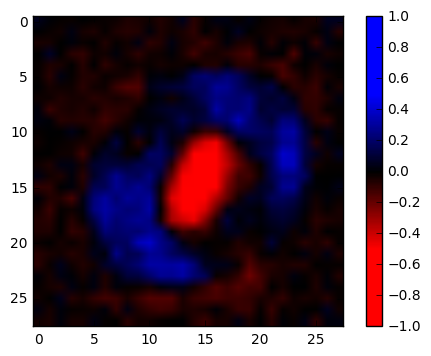

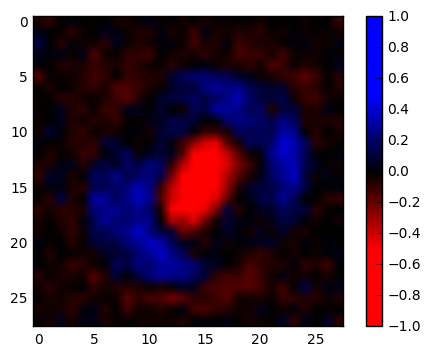

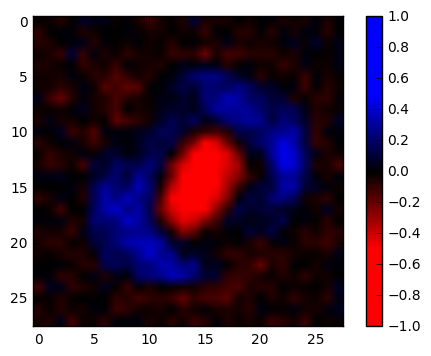

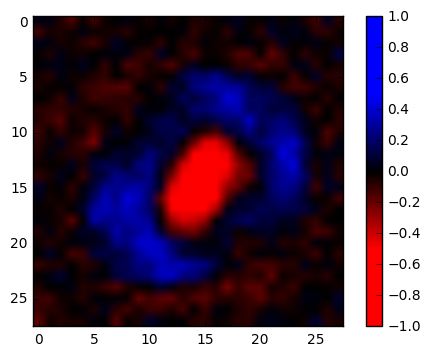

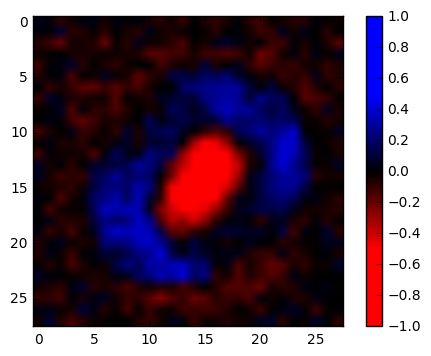

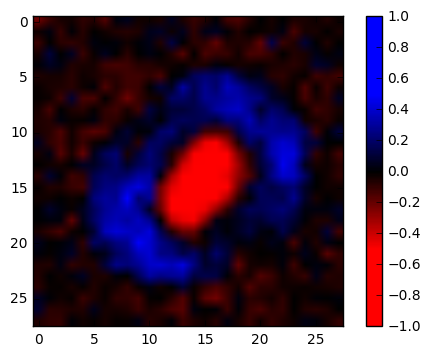

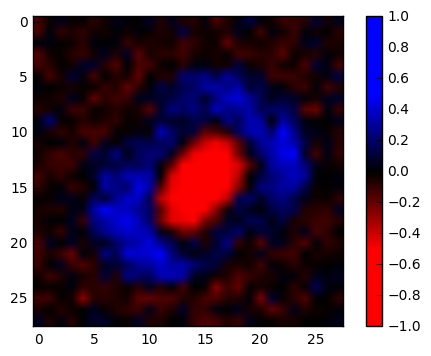

In [598]:
# get the accuracies for the noisy data.
accuracies_noisy = eval_noisy_data(stddevs, digits, labels)

[(0.0, 0.9152), (16.0, 0.91043639), (32.0, 0.91307271), (48.0, 0.90769088), (64.0, 0.90623635), (80.0, 0.89581817), (96.0, 0.8852182), (112.0, 0.87276363), (128.0, 0.8423273), (144.0, 0.83703637), (160.0, 0.81303638), (176.0, 0.7809273), (192.0, 0.76476365)]


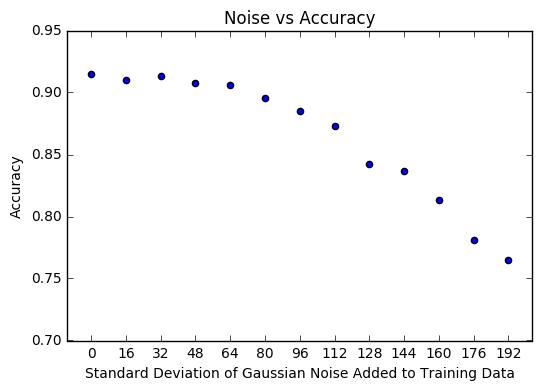

In [616]:
# make nice plot here
print accuracies_noisy
plt.title('Noise vs Accuracy')
plt.xlabel('Standard Deviation of Gaussian Noise Added to Training Data')
plt.ylabel('Accuracy')
plt.xticks(sorted(stddevs))
plt.legend(loc=3)
plt.scatter(*zip(*accuracies_noisy)) # or plot for line
plt.savefig('noise.png')
plt.show()

In [582]:
# ZELLER AND FERGUS BLOB BASED OCCLUSION
from random import randint

#N_apply = 2.5 O (I /H + 1) + 0.5
# O = percent of occlusion [0, 1], number of times to apply the filter
# I = Imagesize (28x28)
# H = width of filter = 5% of 28 


# NO GAUSSIAN YET
def add_blob_occlusion(mnist_digits, occ_perc):
    ''' 
    This function adds occlusions to the matrix representations
    of the mnist digits
    IN:   
        (1) np array: the MNIST digit representations (n, 784)
        (2) float: percentage of occlusion after Zeiler and Fergus [0, 1]
    OUT: 
        (1) np array: occluded training data (n, 784)
        
    From Zeiler
    The blob-based occlusion algorithm involved the construction of a 
    filter that was set to 1.0 within a circle of radius 5% of the image size 
    (i.e., 5% of 144 pixels or 7 pixels) and then fell off outside   
    
    '''
    # img is 28x28 pixels
    n = 28
    n_apply = 2.5 * occ_perc * (n / (n/20.00) + 1) + 0.5
    # print "applying " + str(int(n_apply)) + " filters"
    # copy because we are going to modify them.
    occluded_digits = np.copy(mnist_digits)
    counter = 0
    for digit in occluded_digits:
        # plt.imshow(mnist_digits[counter].reshape(n,n), cmap = cm.Greys)
        # plt.show()
        # reshape to size n,n
        occluded_digit = digit.reshape(n,n)
        for i in range(int(n_apply)):
            # randint is inclusive
            # make (2, n-r)
            r = 2 # floor(28/20) = 1.4 # Zeiler 144/20 = 7.2
            a = randint(0,n)
            b = randint(0, n)
            # the coordinates
            y,x = np.ogrid[-a:n-a, -b:n-b]
            # create the circular mask
            mask = x*x + y*y <= r*r
            
            # GAUSSIAN HERE??
            # without gaussian you could potentially create new features.
            
            array = np.zeros((n, n))
            # set all values to -1 (neg numbers clipped later)
            array[mask] = -1
            # add the negative values (1-1 = 0 so the max is occluded as well)
            # could also need a gaussian fall off here
            occluded_digit = occluded_digit+array
            # make it in range 0,1 so negative numbers become 0. 
            occluded_digit = np.clip(occluded_digit, 0., 1.)
        
        # set the occluded digit in the nparray
        occluded_digits[counter] = occluded_digit.reshape(784,)
        counter+=1;
   
    return occluded_digits

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ]


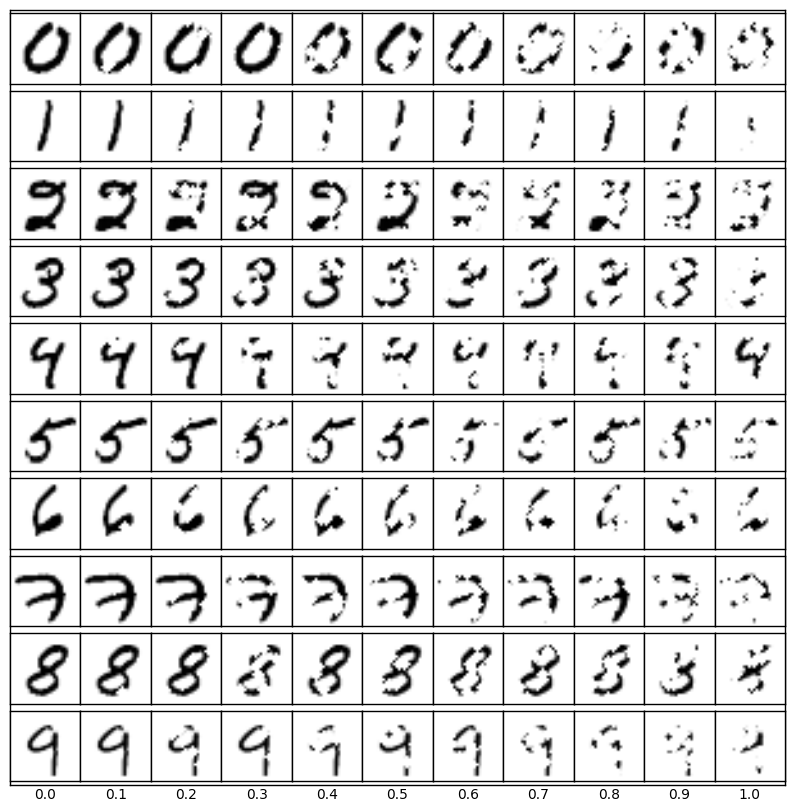

In [583]:
def show_all_occluded_digits(occ_perc, digits, label):
    ''' 
    IN:  
        (1) 1D numpy array: standard deviations of the Gaussian noise to add
            to example images from the X training data. Note that the image
            data has not yet been scaled from 0 to 1, 
        (2) (784, ) np array: the MNIST digit representation
        (3) 1D numpy array: y training data: the first instance of each digit
            will be taken from these labels so that an example of each
            digit can be shown
            EXAMPLE: [0,0,1,0,0,0,0,0,0,0] = the digit 2
    OUT: Plots
    
    This function displays an example of each digit from the X training data
    with increasing levels of occlusions of it. The function is 
    hardcoded such that 10 examples of increasing noise will be shown. 
    '''
    fig = plt.figure(figsize=(10,10))
    outer_grid = gridspec.GridSpec(10, 11, wspace=0.0, hspace=0.0)
    pylab.xticks([])
    pylab.yticks([])
    
    # more efficient
    first_ind_of_each_num = {}
    for i in range(10):
        counter = 0
        # by inspection: this is enough
        while counter < 100: #len(mnist.test.labels):
            position = np.where(labels[counter] == 1)[0][0]
            if position not in first_ind_of_each_num:
                first_ind_of_each_num[position] = counter
            counter +=1
    # loop through every occlusion percentage
    for col_ind, occ_perc in zip(range(11), occ_percs):  
        # digit_occ = add_blob_occlusion(digit, occ_perc)
        
        for row_ind in range(10):
            ind_to_plot = col_ind + row_ind * 11
            ax = plt.Subplot(fig, outer_grid[ind_to_plot])
            first_ind_of_this_num = first_ind_of_each_num[row_ind]
            digit_occ = add_blob_occlusion([digits[first_ind_of_this_num]], occ_perc)
            '''[first_ind_of_this_num]'''
            ax.imshow(digit_occ.reshape((28,28)), 
                      cmap=plt.cm.Greys)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
            if ax.is_last_row():
                ax.set_xlabel('{}'.format(occ_perc))
            plt.subplots_adjust(wspace=0.0,hspace=0.0)
    plt.show()
    
occ_percs = np.linspace(0,1,11)
show_all_occluded_digits(occ_percs, digits, labels)

In [605]:
def eval_occluded_data(occ_percs, digits, labels):
    ''' 
    This function trains the model on the respective noises
    IN:  
        (1) List: list of std deviations (stddevs)
    OUT: 
        (1) List: list of tuples (Noise, accuracy)
    '''
    accuracies_occ = []
    for occ_perc in occ_percs:
        # create the noisy data with the noise_vals
        # use training images 555000
        x_occ = add_blob_occlusion(digits[:], occ_perc)
        # create the iterator
        iter_ = data_iterator(x_occ, labels)
        
        # MODEL HERE 
        ##
        x = tf.placeholder(tf.float32, [None, 784])
        # 10 weights to learn
        w1 = tf.Variable(tf.zeros([784, 10]))
        # 10 biases to learn
        b1 = tf.Variable(tf.zeros([10]))

        #layer 2
        w2 = tf.Variable(tf.zeros([10, 10]))
        b2 = tf.Variable(tf.zeros([10]))

        # use softmax as activation
        # other options: sigmoid, softplus
        # SINGLE LAYER
        y = tf.nn.softmax(tf.matmul(x, w1) + b1)
        # 2 LAYER
        # y1 = tf.matmul(y1, w1) + b1
        # y = tf.nn.softmax(tf.matmul(y1, w2) + b2)

        y_ = tf.placeholder(tf.float32, [None, 10])

        cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
        
        # use gradient descent just because.
        train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

        init = tf.initialize_all_variables()
        sess = tf.Session()
        sess.run(init)

        # train 1000 batches of size 100 (defined in iterator function)
        for _ in range(1000):
            batch_xs, batch_ys = iter_.next()  #mnist.train.next_batch(100)
            sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

        correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        final = sess.run(accuracy, feed_dict={x: x_occ, y_: labels})
        
        # append to the list
        accuracies_occ.append((occ_perc, final))
        print final
        # weight activations
        wts = w1.eval(sess)
        # digit 0 activation
        im = wts.flatten()[0::10].reshape((28,-1))
        plt.imshow(im, cmap = redblue, clim=(-1.0, 1.0))
        plt.colorbar()
        plt.show()
        
    return accuracies_occ

0.916418


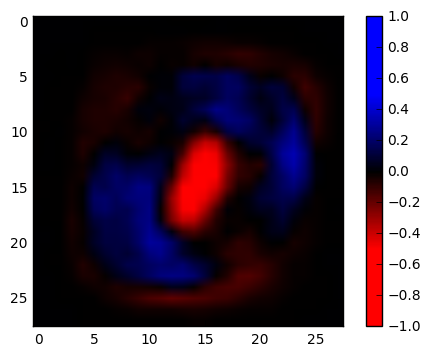

0.893782


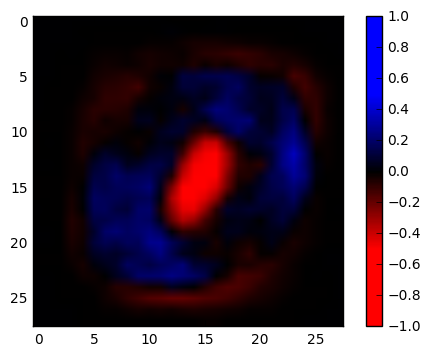

0.864636


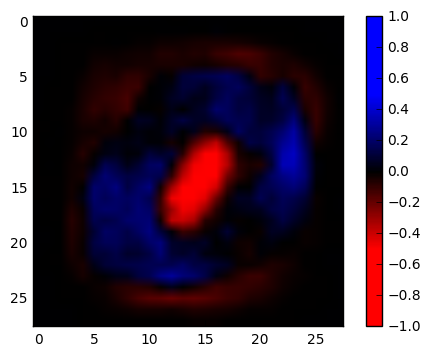

0.849745


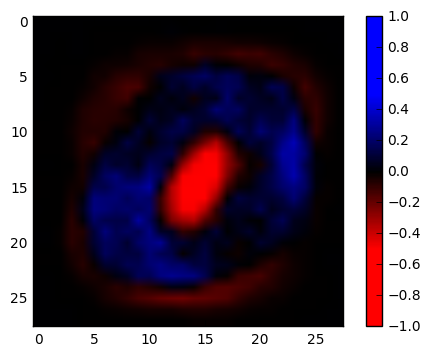

0.835291


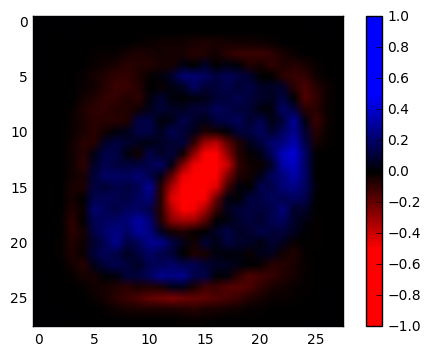

0.820473


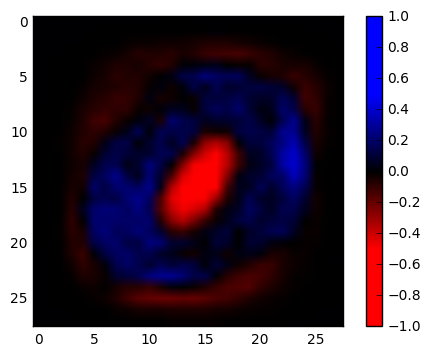

0.804436


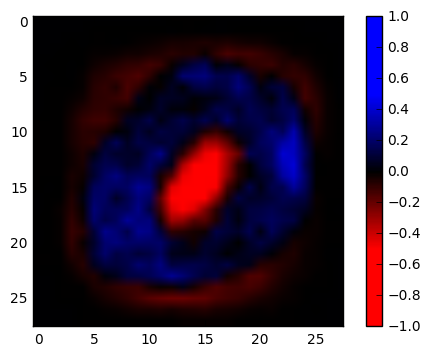

0.783018


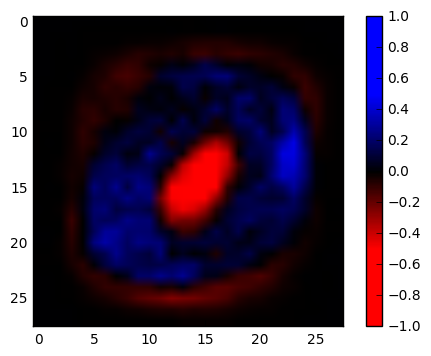

0.765182


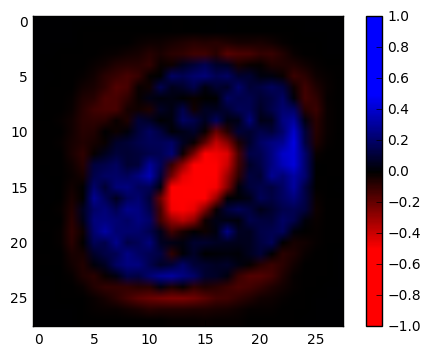

0.757545


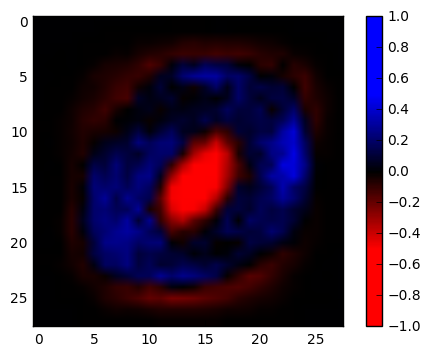

0.733145


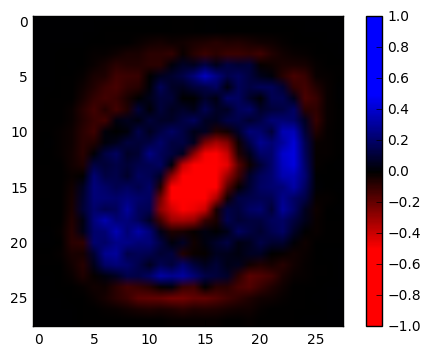

In [607]:
accuracies_occ = eval_occluded_data(occ_percs, digits, labels)

[(0.0, 0.91641819), (0.10000000000000001, 0.89378184), (0.20000000000000001, 0.86463636), (0.30000000000000004, 0.84974545), (0.40000000000000002, 0.83529091), (0.5, 0.82047272), (0.60000000000000009, 0.80443639), (0.70000000000000007, 0.78301817), (0.80000000000000004, 0.76518184), (0.90000000000000002, 0.75754547), (1.0, 0.73314548)]


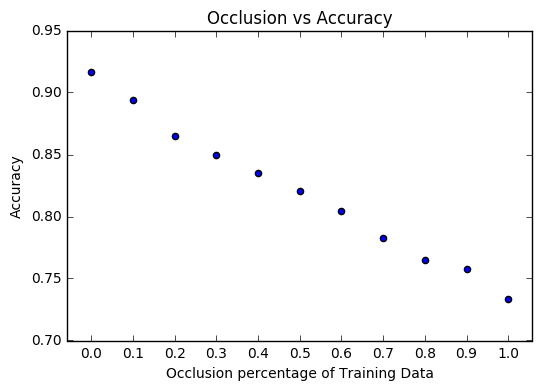

In [615]:
print accuracies_occ
plt.title('Occlusion vs Accuracy')
plt.xlabel('Occlusion percentage of Training Data')
plt.ylabel('Accuracy')
plt.xticks(sorted(occ_percs))
plt.legend(loc=3)
plt.scatter(*zip(*accuracies_occ)) # or plot for line
plt.savefig('occlusion.png')


plt.show()

